# Set Up
## Imports

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as pl

from PIL import Image
from functools import reduce
from collections import Counter
from matplotlib.pyplot import cm
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

tls.set_credentials_file(username='jvani', api_key=os.getenv('PLOTLY_API'))

## Load in Trump Regret Tweets

In [3]:
z = zipfile.ZipFile('bkey-trump-regrets-tweets.zip')
df = pd.read_csv(z.open('bkey-trump-regrets-tweets/trump_regrets_tweets.csv'))
df.created_at = pd.to_datetime(df.created_at, infer_datetime_format=True)
df.head(2)

,id,user_id,created_at,tweet_text,hashtag_entities,url_entities,user_entities,favorites_count,retweet_count,quoted_status_id,in_reply_to_status_id
0,801162154896453633,801159713035612160,2016-11-22 20:35:17,RT @the1ladycham: @realDonaldTrump MSM says yo...,{LockHerUp},{},"{2600774276,25073877}",0,2,NaN,NaN
1,801162417912823808,801159713035612160,2016-11-22 20:36:19,RT @BunkShaner: @realDonaldTrump #CrookedHilla...,"{CrookedHillary,LockHerUp}",{},"{97517291,25073877}",0,3,NaN,NaN


# Looking Into @Trump_Regret Tweets
## What are the most common hashtags?

In [4]:
hashtags = []

for i in df.hashtag_entities:
    for h in i.lstrip('{').rstrip('}').split(','):
        if h != '':
            hashtags.append(h.lower())
hashtag_count = sorted(Counter(hashtags).items(), key=lambda x: x[1], reverse=True)
hashtag_count[:5]

[('lockherup', 69),
 ('draintheswamp', 14),
 ('trump', 14),
 ('maga', 12),
 ('crookedhillary', 9)]

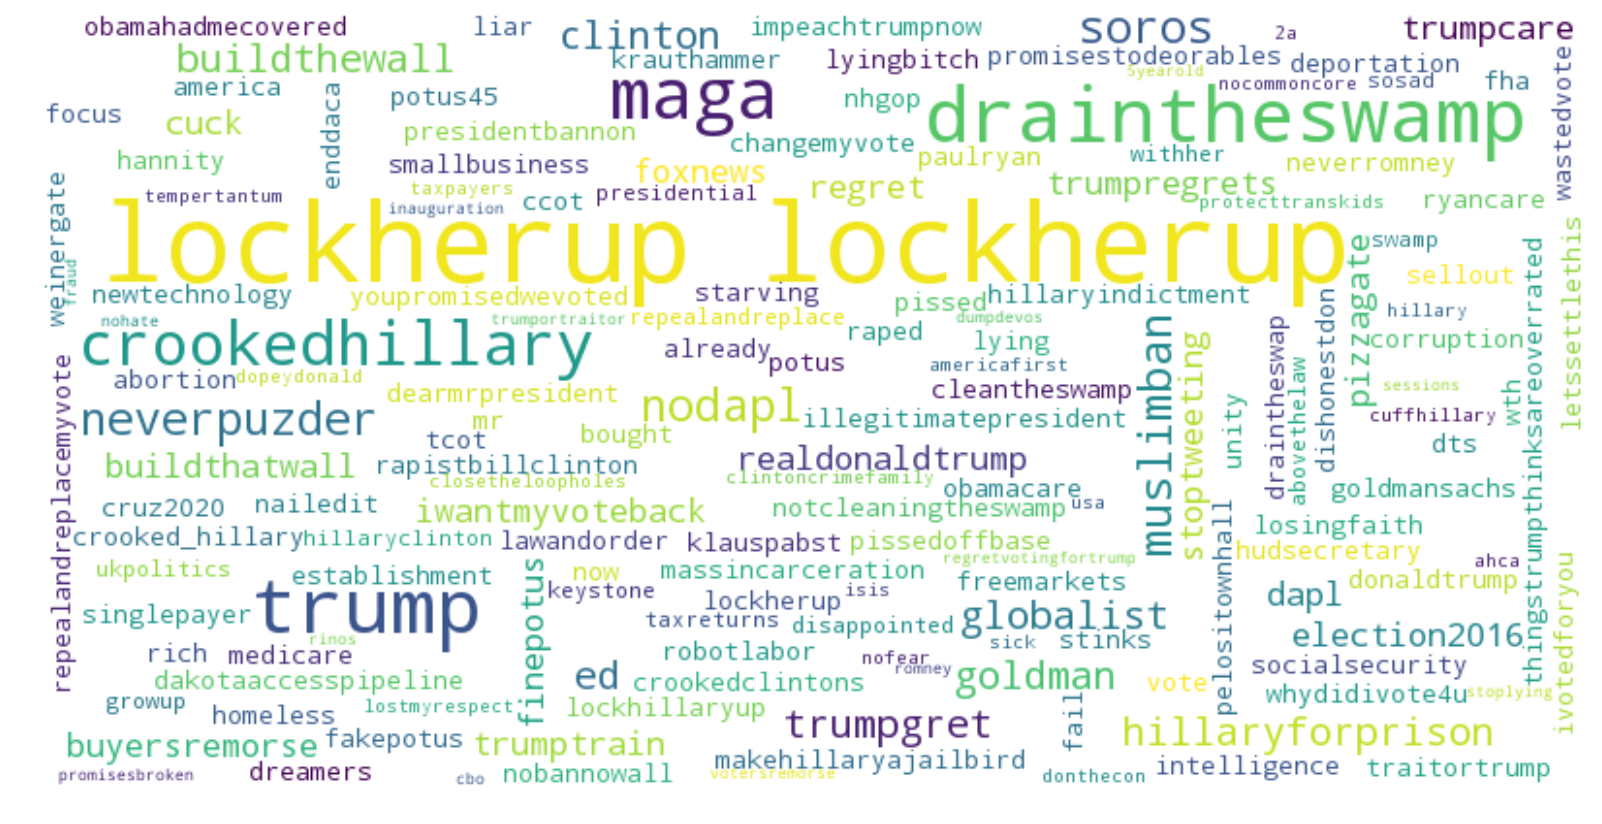

In [5]:
text = ' '.join(hashtags)
wc = WordCloud(width=800, height=400, background_color="white").generate(text)
pl.figure(figsize=(20, 10))
pl.imshow(wc, interpolation='bilinear', aspect='auto')
pl.axis("off")
pl.show()

In [6]:
data = [go.Bar(
    x=[x[1] for x in reversed(hashtag_count[:20])],
    y=[x[0] for x in reversed(hashtag_count[:20])],
    orientation='h',
    marker=dict(color='#EF5350'))]
layout = go.Layout(
    title='@Trump_Regret Tweets Hashtag Counts (Top Twenty Hashtags)')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='D4D_TrumpRegretTweets')

## What are the most common hashtags, incorporating favorites and retweets?

In [6]:
hashtags_weighted = []
for index, row in df.iterrows():
    for h in row['hashtag_entities'].lstrip('{').rstrip('}').split(','):
        if h != '':
            hashtags_weighted.append((h.lower(), 1 + row['favorites_count'] + row['retweet_count']))

c = Counter()
for k, v in hashtags_weighted:
    c[k] += v

hashtags_weighted = sorted(c.items(), key=lambda x: x[1], reverse=True)
hashtags_weighted[:5]

[('maga', 1503),
 ('obamahadmecovered', 1418),
 ('crookedhillary', 1128),
 ('muslimban', 1075),
 ('nodapl', 888)]

In [8]:
data = [go.Bar(
    x=[x[1] for x in reversed(hashtags_weighted[:20])],
    y=[x[0] for x in reversed(hashtags_weighted[:20])],
    orientation='h',
    marker=dict(color='#EF5350'))]
layout = go.Layout(
    title='@Trump_Regret Tweets Hashtag Weighted Counts (Tweets + Retweets + Favorites)')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='D4D_TrumpRegretTweets_Weighted')

## When were the tweets tweeted?

In [7]:
tweets_grouped_date = df.groupby(df['created_at'].map(lambda x: '{2}-{1}-{0}'.format(x.day, x.month, x.year))).count()[[0]]
tweets_grouped_date.reset_index(inplace=True)
tweets_grouped_date.created_at = pd.to_datetime(tweets_grouped_date.created_at, infer_datetime_format=True)
tweets_grouped_date.sort_values('created_at', inplace=True)

e = ['Devos Nomination',
     'Dakota Access Pipeline Blocked',
     'Kellyanne Conway denies Russian Interference',
     'Pres. Obama awards Presidential Medal \nof Freedom with Distinction to Joe Biden',
     'Exec. Order to Build Wall',
     'Muslim Ban Start Date.',
     'Trump Appeal of Muslim Ban Denied']

events = tweets_grouped_date.sort_values('id', ascending=False)[:9].drop([0, 90]).sort_values('created_at')
events['label'] = e

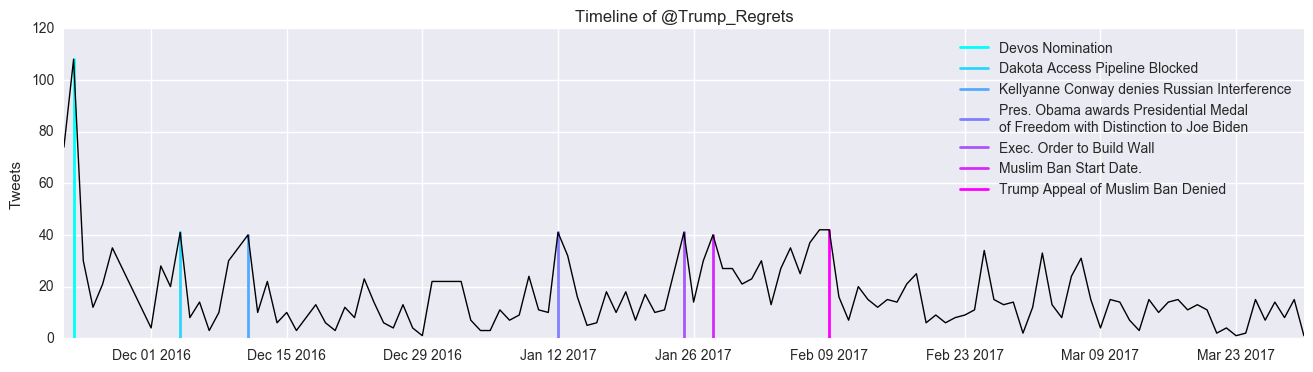

In [8]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16, 4))

ax.plot(tweets_grouped_date.created_at, tweets_grouped_date.id, c='k', lw=1, label='__nolegend__', zorder=10)
color = iter(cm.cool(np.linspace(0,1,7)))
for row in events.iterrows(): 
    c=next(color)
    ax.axvline(row[1]['created_at'], ymax=row[1]['id']/120, label=row[1]['label'], lw=2, alpha=1, c=c)

ax.set_ylabel('Tweets')
ax.set_title('Timeline of @Trump_Regrets')
ax.legend()